In [ ]:
import pymc3 as pm
import numpy as np
import pandas as pd
import datetime as dt
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; 
%matplotlib inline

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/nacional_covid19.csv', sep=',').fillna(0)
df['dias'] = pd.to_datetime(df['fecha'])
df['dias'] = (df['dias'] - np.datetime64('2020-02-25')) / np.timedelta64(1, 'D')
df

In [ ]:
# We count te number of days since the beginning of register
t = len(df)
t

In [ ]:
# We define the variables we are going to work with
d = df['fecha']
x = df['dias']
y = df['casos']
a = df['altas']
f = df['fallecimientos']
g = df['ingresos_uci']
h = df['hospitalizados']

In [ ]:
# Let's take a look at the whole picture
with plt.style.context('Solarize_Light2'):
   
    fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True, figsize=(15, 10))
    fig.suptitle('Evolucion de los casos COVID19 en ES', fontsize=20)
    plt.rcParams['lines.linewidth'] = 5
    
    ax1.plot(x, y, label='casos', color='r')  
    ax1.set_ylabel('Numero de casos', fontsize=14)
    
    ax2.plot(x, a, label='altas', color= 'b') 
    ax2.set_ylabel('Altas', fontsize=16)
    
    ax3.plot(x, f, label='hospitalizados', color='g') 
    ax3.set_xlabel('Dias desde el inicio', fontsize=18)
    ax3.set_ylabel('Fallecimientos', fontsize=16)
    
    plt.xlim(0,40)
    
plt.show()

In [ ]:
sns.set(context= "notebook", style="ticks")
dfn = df.drop(columns=["fecha","dias"])
from scipy import stats
g = sns.PairGrid(dfn, palette="tab20c")
g.map_upper(sns.regplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=1)

# Evolution of COVID19 spread

# Option 1: Kenerlized Regression

We are going to write a function to compute a Gaussian kernel. The Kernel function or Covariance function, allows us to apply the Bayesian framework with linear model to any function.

In [ ]:
def gauss_kernel(x, n_knots):
    """
    Simple Gaussian radial kernel
    """
    knots = np.linspace(x.min(), x.max(), n_knots)    
    w = 2 
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

In [ ]:
n_knots = t

We write our model as a linear regression and findout 'gamma' coefficients:

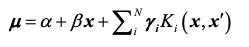

In [ ]:
with pm.Model() as kernel_model:
    gamma = pm.Laplace('gamma', mu=0, b=1, shape=n_knots)
    sd = pm.Uniform('sd', 0, 100)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal('yl', mu=mu, sd=sd, observed=y)
    kernel_trace = pm.sample(10000, step=pm.Metropolis())

In [ ]:
# We run the model several times in parallel 
chain = kernel_trace[5000:]
pm.traceplot(chain);

In [ ]:
# Gelman-Rubin test (Rhat). Rhat ideally should expect a value R = 1 or, at least, R < 1.0 and < 1.1
# mc_error: Estimation of the error introduced by the sampling method.
pm.summary(chain)

In [ ]:
#Kruschke's plot
pm.plot_posterior(chain, kde_plot=True)

In [ ]:
ppc = pm.sample_posterior_predictive(chain, model=kernel_model, samples=1000)

fig = plt.figure(figsize=(18, 7))
plt.plot(x, ppc['yl'].T, 'ro', alpha=0.1)
plt.plot(x, y, 'bo')

plt.xlabel('dia', fontsize=16, rotation=0)
plt.ylabel('casos', fontsize=16, rotation=90 )

In [ ]:
fig = plt.figure(figsize=(18, 7))
new_x = np.linspace(x.min(), x.max(), 1000)
k = gauss_kernel(new_x, n_knots)
gamma_pred = chain['gamma']
for i in range (1000):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'r-', alpha=.5)
plt.plot(x, y, 'bo')
plt.xlabel('dia', fontsize=16)
plt.ylabel('casos', fontsize=16, rotation=90)

# Option 2: Gaussian Processes

In [ ]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

In [ ]:
fig = plt.figure(figsize=(18, 7))
np.random.seed(1)
test_points = np.linspace(1, 100, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('dias', fontsize=16)
plt.ylabel('casos', fontsize=16, rotation=90)

In [ ]:
fig = plt.figure(figsize=(18, 7))
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03
D = squared_distance(test_points, test_points)

cov = eta * np.exp(-rho * D)
diag = eta * sigma

np.fill_diagonal(cov, diag)

for i in range(6):
    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('dias', fontsize=16)
plt.ylabel('casos', fontsize=16, rotation=90)

In [ ]:
fig = plt.figure(figsize=(18, 7))
np.random.seed(1)

K_oo = eta * np.exp(-rho * D) 

D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag_x)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

# Posterior mean
mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)

# Posterior covariance
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)


for i in range(1000):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.5)

plt.plot(x, y, 'o')
 
plt.xlabel('dias', fontsize=16)
plt.ylabel('casos', fontsize=16, rotation=90)


In [ ]:
fig = plt.figure(figsize=(18, 7))
np.random.seed(1)

K_oo = eta * np.exp(-rho * D) 

D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag_x)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

# Posterior mean
mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)
# Posterior covariance
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)


for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.1)

plt.plot(x, y, 'o')
plt.xlabel('dia', fontsize=16)
plt.ylabel('casos', fontsize=16, rotation=90)


In [ ]:
fig = plt.figure(figsize=(18, 7))
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(x).flatten()

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    D = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return eta * np.exp(- rho * D)

N = t      # number of training points.
n = 2000        # number of test points.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(1,100, size=(N,1))


K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(1, 100, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5


plt.fill_between(Xtest.flat, mu - 2 * sd_pred, mu + 2 * sd_pred, color="r", alpha=0.2)
plt.plot(Xtest, mu, 'r', lw=2)
plt.plot(x, y, 'o')
plt.xlabel('dias', fontsize=16)
plt.ylabel('casos', fontsize=16, rotation=90)

In [ ]:
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', beta=0.5)
    rho = pm.HalfCauchy('rho', beta=0.5)
    sigma = pm.HalfCauchy('sigma', beta=0.5)
    
    D = squared_distance(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(1, 100, 150)
    D_pred = squared_distance(test_points, test_points)
    D_off_diag = squared_distance(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    trace = pm.sample(1000, step=pm.Metropolis())

In [ ]:
fig = plt.figure(figsize=(14, 14))
varnames = ['eta', 'rho', 'sigma']
chain = trace[500:]
pm.traceplot(chain, varnames)

In [ ]:
# Gelman-Rubin test (Rhat). Rhat ideally should expect a value R = 1 or, at least, R < 1.0 and < 1.1
# mc_error: Estimation of the error introduced by the sampling method.
pm.summary(chain, varnames).round(2)

In [ ]:
from datetime import date
today = date.today()

fig = plt.figure(figsize=(18, 20))
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]
    
for yp in y_pred: 
    plt.suptitle("EVOLUCION DE LOS CASOS DE COVID19 EN ESP", fontweight=800, fontsize=24 )
    plt.title(today, fontweight=800, fontsize=24 )
   
    # posterior predictive distribution
    plt.plot(test_points, yp, 'grey', alpha=0.2, ms=5, label="Predicted data")
    plt.plot(test_points, m, 'r', alpha=0.1 , ms=50)

# plot original data 
plt.plot(x, y,'bo', ms=3, alpha=1.0, label="observed data")

#pico de casos más probable (en días desde el inicio)
my= np.max(m, axis=0)

plt.xlim(0, 80)
plt.ylim(-50, 100000)
plt.axvline(x= t-1, ymin=0, ymax=100000)
plt.xlabel('Dias desde el inicio', fontsize=18)
plt.ylabel('Nuevos casos acumulados', fontsize=18, rotation=90)
plt.savefig('/Users/javiermarin/desktop/COVID.png')
plt.show()